# RNN Time Series for OPEC Predictions

In [65]:
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
import sklearn.preprocessing
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn
import quandl

In [66]:
quandl.ApiConfig.api_key = "EodKRXnzq6S5xDQy1ZBQ"

Total Data = 3939 days


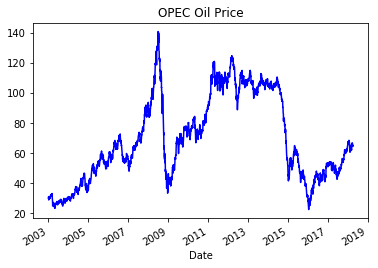

Date
2018-04-06    64.82
2018-04-05    65.18
2018-04-04    64.48
2018-04-03    64.98
2018-04-02    66.09
2018-03-29    65.87
2018-03-28    66.06
2018-03-27    66.81
2018-03-26    66.81
2018-03-23    66.40
Name: Value, dtype: float64

In [67]:
from pandas import Series
def parser(x):
    return pd.to_datetime(x, format='%Y-%m-%d')
OPEC_Data = pd.read_csv('OPEC.csv',  header=0 , parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print('Total Data = {0} days'.format(len(OPEC_Data)))
OPEC_Data.plot(c='b', title='OPEC Oil Price')
plt.show()
OPEC_Data.head(10)


In [68]:
OPEC_Data.describe()

count    3939.000000
mean       69.206971
std        28.389810
min        22.480000
25%        46.255000
50%        63.020000
75%        99.125000
max       140.730000
Name: Value, dtype: float64

#### Convert data into array that can be broken up into training "batches" that we will feed into our RNN model.  

In [94]:
scaler = sklearn.preprocessing.MinMaxScaler()
normData = scaler.fit_transform(OPEC_Data.values.reshape(-1,1))
TS = np.array(normData)

num_periods = 360 #number of periods per vector we are using to predict one period ahead
f_horizon = 1  #forecast horizon, one period into the future

x_data = TS[:(len(TS)-(len(TS) % num_periods))]
x_batches = x_data.reshape(-1, num_periods, 1)

y_data = TS[1:(len(TS)-(len(TS) % num_periods))+f_horizon]
y_batches = y_data.reshape(-1, num_periods, 1)
print (len(x_batches))
print (len(y_batches))
print (x_batches.shape)
print (y_batches.shape)

10
10
(10, 360, 1)
(10, 360, 1)


#### Pull out our test data

In [95]:
def test_data(series,forecast,num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, num_periods, 1)
    testY = TS[-(num_periods):].reshape(-1, num_periods, 1)
    return testX,testY

X_test, Y_test = test_data(TS,f_horizon,num_periods )
#print (X_test.shape)
#print (X_test)

In [96]:
tf.reset_default_graph()   #We didn't have any previous graph objects running, but this would reset the graphs

inputs = 1            #number of vectors submitted
hidden = 50          #number of neurons we will recursively work through, can be changed to improve accuracy
output = 1            #number of output vectors

X = tf.placeholder(tf.float32, [None, num_periods, inputs])   #create variable objects
y = tf.placeholder(tf.float32, [None, num_periods, output])


basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)   #create our RNN object
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)               #choose dynamic over static

learning_rate = 0.001   #small learning rate so we don't overshoot the minimum

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])           #change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)        #specify the type of layer (dense)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])          #shape of results
 
loss = tf.reduce_sum(tf.square(outputs - y))    #define the cost function which evaluates the quality of our model
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)          #gradient descent method
training_op = optimizer.minimize(loss)          #train the result of the application of the cost_function                                 

init = tf.global_variables_initializer()           #initialize all the variables

In [97]:
epochs = 2000     #number of iterations or training cycles, includes both the FeedFoward and Backpropogation

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 50 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            #print(ep, "\tMSETrain:", scaler.inverse_transform(mse.reshape(-1,1)))
            mseTest = loss.eval(feed_dict={X: X_test, y: Y_test}) #X_test, Y_test
            print(ep, "MSETrain:{0} \tMSETest:{1} "
                  .format(scaler.inverse_transform(mse.reshape(-1,1)), scaler.inverse_transform(mseTest.reshape(-1,1))))
    
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    #print(y_pred)

0 MSETrain:[[94532.05]] 	MSETest:[[154.33803]] 
50 MSETrain:[[875.6708]] 	MSETest:[[296.08725]] 
100 MSETrain:[[250.70654]] 	MSETest:[[54.244564]] 
150 MSETrain:[[178.99246]] 	MSETest:[[25.158249]] 
200 MSETrain:[[124.54208]] 	MSETest:[[23.783176]] 
250 MSETrain:[[90.73372]] 	MSETest:[[24.064522]] 
300 MSETrain:[[75.28401]] 	MSETest:[[24.233166]] 
350 MSETrain:[[67.43489]] 	MSETest:[[23.884111]] 
400 MSETrain:[[62.068848]] 	MSETest:[[23.347855]] 
450 MSETrain:[[59.301987]] 	MSETest:[[23.438894]] 
500 MSETrain:[[57.801716]] 	MSETest:[[23.497295]] 
550 MSETrain:[[56.839554]] 	MSETest:[[23.554064]] 
600 MSETrain:[[56.160088]] 	MSETest:[[23.59296]] 
650 MSETrain:[[55.881214]] 	MSETest:[[23.679092]] 
700 MSETrain:[[55.464947]] 	MSETest:[[23.697678]] 
750 MSETrain:[[55.27967]] 	MSETest:[[23.740864]] 
800 MSETrain:[[55.17957]] 	MSETest:[[23.77145]] 
850 MSETrain:[[55.050903]] 	MSETest:[[23.801702]] 
900 MSETrain:[[55.050014]] 	MSETest:[[23.838453]] 
950 MSETrain:[[54.84559]] 	MSETest:[[23.881

In [60]:
#### Actual vs predictions against test batch 

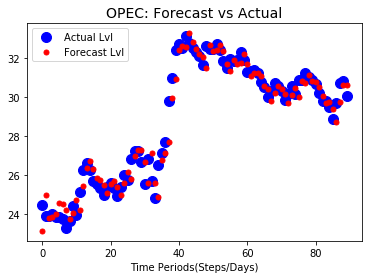

In [64]:
plt.title("OPEC: Forecast vs Actual", fontsize=14)
testset = scaler.inverse_transform(Y_test.reshape(-1,1))
prediction = scaler.inverse_transform(y_pred.reshape(-1,1))
plt.plot(pd.Series(np.ravel(testset)), "bo", markersize=10, label="Actual Lvl")
#plt.plot(pd.Series(np.ravel(Y_test)), "w*", markersize=10)
plt.plot(pd.Series(np.ravel(prediction)), "r.", markersize=10, label="Forecast Lvl")
plt.legend(loc="upper left")
plt.xlabel("Time Periods(Steps/Days)")

plt.show()

